# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pprint
pp = pprint.PrettyPrinter(indent=4)

import acctrack.utils.ctd2021_data as data_helper
from acctrack.io.athena_raw_data import AthenaRawDataReader


# Read in data

In [3]:
run_number = 242020
event_number = 24723
evtid = data_helper.find_event_index(event_number)


In [4]:
gnn_basedir = "/media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/GNN_noRemoval"
ckf_basedir = "/media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/CKF_noRemoval"
gnn_reader = AthenaRawDataReader(gnn_basedir, overwrite=True, name="GNN")
ckf_reader = AthenaRawDataReader(ckf_basedir, overwrite=True, name="CKF")

Total 1 events in directory: /media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/GNN_noRemoval
Total 1 events in directory: /media/DataOcean/projects/tracking/integrateToAthena/run_21.9.26/RunOneEventForDebuging/CKF_noRemoval


In [5]:
gnn_reader.read(event_number=event_number)
ckf_reader.read(event_number=event_number)

# Basic Track Contents

Common tracks means the track contents are exactly the same.

In [6]:
num_gnn_tracks = len(gnn_reader.tracks_clusters)
num_ckf_tracks = len(ckf_reader.tracks_clusters)
print("num_gnn_tracks: ", num_gnn_tracks)
print("num_ckf_tracks: ", num_ckf_tracks)

num_gnn_tracks:  2012
num_ckf_tracks:  2077


In [7]:
min_num_clusters = 5
gnn_filtered = [x for x in gnn_reader.tracks_clusters if len(x) >= min_num_clusters]
ckf_filtered = [x for x in ckf_reader.tracks_clusters if len(x) >= min_num_clusters]

num_fil_gnn_tarcks = len(gnn_filtered)
num_fil_ckf_tracks = len(ckf_filtered)

print("filtered num_gnn_tracks: ", num_fil_gnn_tarcks)
print("filtered num_ckf_tracks: ", num_fil_ckf_tracks)

filtered num_gnn_tracks:  1821
filtered num_ckf_tracks:  2077


In [8]:
a = {1,2,3,4}
b = {1,2,3,5}
print(a == b)
print(a < b)
print(a > b)
print(a & b)
print(a - b)
print(a ^ b)
print(a.isdisjoint(b))

False
False
False
{1, 2, 3}
{4}
{4, 5}
False


* For each GNN track, find the closest CKF track that contains the same clusters. 
* Matched means the track contents are exactly the same. 
* That X is a subset means the track contents in X are a subset of the track contents in Y. 
* Disjoint means the track contents are disjoint (no common clusters). 

In [9]:
def compare_tracks(track_reader, other_track_reader, min_num_clusters=5):
    """tracks compared to other_tracks"""
    label= track_reader.name
    other_label = other_track_reader.name
    tracks = track_reader.tracks_clusters
    other_tracks = other_track_reader.tracks_clusters

    print(f"{label} compared to {other_label}")
    num_matched = 0
    num_issubset = 0
    num_other_issubset = 0
    num_disjoints = 0

    unmatched_tracks = []
    disjoint_tracks = []
    common_tracks = []

    tot_tracks = len(tracks)

    tot_filtered_tracks = 0
    for trkid,track in enumerate(tracks):
        if len(track) < min_num_clusters:
            continue
        tot_filtered_tracks += 1
        found_a_match = False
        all_disjoint = True
        found_as_subset = False
        found_other_as_subset = False
        ckf_idx = -1

        for idx,other_track in enumerate(other_tracks):
            track_set = set(track)
            other_track_set = set(other_track)
            if not track_set.isdisjoint(other_track_set):
                all_disjoint = False
            if track_set == other_track_set:
                found_a_match = True
                ckf_idx = idx
            if track_set < other_track_set:
                found_as_subset = True
            if track_set > other_track_set:
                found_other_as_subset = True

        if found_a_match:
            num_matched += 1
            common_tracks.append((trkid,track,ckf_idx))
        else:
            unmatched_tracks.append((trkid,track))
        
        if all_disjoint:
            num_disjoints += 1
            disjoint_tracks.append((trkid,track))
        if found_as_subset:
            num_issubset += 1
        if found_other_as_subset:
            num_other_issubset += 1

    print(f"Summary for {label} Tracks")
    print(f"Total {label} tracks: {tot_tracks}, filtered {label} tracks: {tot_filtered_tracks}")
    print("Matched:        ", num_matched, tot_filtered_tracks, num_matched/tot_filtered_tracks)
    print(f"{label} is a subset:", num_issubset, tot_filtered_tracks, num_issubset/tot_filtered_tracks)
    print(f"{other_label} is a subset:", num_other_issubset, tot_filtered_tracks, num_other_issubset/tot_filtered_tracks)
    print("Disjoint:       ", num_disjoints, tot_filtered_tracks, num_disjoints/tot_filtered_tracks)
    return common_tracks, unmatched_tracks, disjoint_tracks

In [10]:
common_fil_gnn_tracks, unmatched_fil_gnn_tracks, disjoint_fil_gnn_tracks = compare_tracks(gnn_reader, ckf_reader, min_num_clusters=5)

GNN compared to CKF
Summary for GNN Tracks
Total GNN tracks: 2012, filtered GNN tracks: 1821
Matched:         771 1821 0.4233937397034596
GNN is a subset: 428 1821 0.23503569467325644
CKF is a subset: 194 1821 0.10653487095002746
Disjoint:        258 1821 0.1416803953871499


In [11]:
common_fil_ckf_tracks, unmatched_fil_ckf_tracks, disjoint_fil_ckf_tracks = compare_tracks(ckf_reader, gnn_reader, min_num_clusters=5)

CKF compared to GNN
Summary for CKF Tracks
Total CKF tracks: 2077, filtered CKF tracks: 2077
Matched:         771 2077 0.3712084737602311
CKF is a subset: 194 2077 0.09340394800192585
GNN is a subset: 449 2077 0.21617717862301397
Disjoint:        491 2077 0.23639865190178141


## True Tracks
This section is to label a track if it is a good track. A track is good if all of its contents are matched to a truth track.

In [12]:
gnn_reader.true_tracks

,trkid,fitter,material,nDoF,chi2,charge,x,y,z,px,...,pz,mot,oot,subevent,barcode,probability,pdgId,status,particle_id,pt
0,0,5,3,1,1.209240,1,21.709999,-17.220400,85.783600,408.217987,...,2342.620117,6,0,5602,200119,1.0,-11,1,56020200119,656.889221
1,1,5,3,1,0.294469,-1,3.704400,4.959140,-72.096703,406.812012,...,4612.330078,3,0,5514,503,1.0,-211,1,55140000503,507.779755
2,2,5,3,3,0.577462,1,-0.424177,0.057936,37.298401,-94.805702,...,11525.400391,4,0,5586,280,1.0,321,1,55860000280,700.563599
3,3,5,3,5,11.910700,1,-15.425600,3.763470,-80.836601,-428.201996,...,19021.699219,5,0,5543,200074,0.8,11,1,55430200074,1806.590210
4,4,5,3,3,0.068077,1,-8.576700,6.303310,-46.327999,-246.557999,...,7730.319824,4,0,5512,404,1.0,-211,1,55120000404,416.340820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,2007,5,3,35,38.334301,1,-0.245878,0.030624,-80.116699,-117.470001,...,-16419.800781,20,0,5529,1591,1.0,321,1,55290001591,950.448242
2008,2008,5,3,13,2.493920,-1,-0.059898,0.046971,20.617800,-1760.459961,...,-39237.300781,9,0,5655,1668,1.0,-211,1,56550001668,2852.936035
2009,2009,5,3,23,12.198000,-1,0.012162,-0.028895,-24.950100,-1505.859985,...,-27041.400391,14,0,5621,553,1.0,-321,1,56210000553,1633.819092
2010,2010,5,3,21,5.600050,-1,0.020114,-0.034423,22.863100,-1032.369995,...,-15135.599609,13,0,5630,1283,1.0,-321,1,56300001283,1195.697388


In [13]:
def match_to_truth(reader):
    detailed = reader.detailed_matching
    all_matched_to_truth = detailed[ 
    (detailed.reco_pixel_hits == detailed.common_pixel_hits) \
    & (detailed.reco_sct_hits == detailed.common_sct_hits) ]
    num_all_matched_to_truth = len(all_matched_to_truth)

    frac_all_matched_to_truth = num_all_matched_to_truth / len(detailed)
    print(f"All matched to truth {reader.name}: ", num_all_matched_to_truth, len(detailed), frac_all_matched_to_truth)
    return all_matched_to_truth

In [14]:
gnn_tracks_matched_to_truth = match_to_truth(gnn_reader)
ckf_tracks_matched_to_truth = match_to_truth(ckf_reader)

All matched to truth GNN:  1816 2422 0.749793559042114
All matched to truth CKF:  1876 2442 0.7682227682227682


In [15]:
gnn_reader.detailed_matching['num_matched'].value_counts()

1    2171
2     232
3      18
4       1
Name: num_matched, dtype: int64

In [16]:
ckf_reader.detailed_matching['num_matched'].value_counts()

1    2215
2     204
3      20
4       2
7       1
Name: num_matched, dtype: int64

# Disjoint Tracks

Disjoint tracks are the tracks that are found only by one algorithm but not the other. 
A good disjoint track is a disjoint track whose contents are all matched to a truth track.

Text(0.5, 0, 'number of clusters')

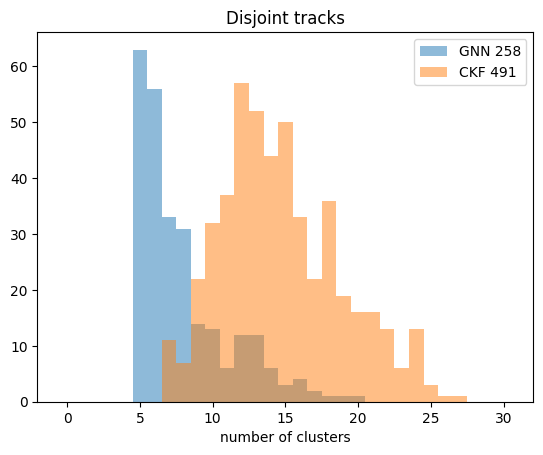

In [17]:
num_gnn_disjoints = len(disjoint_fil_gnn_tracks)
num_ckf_disjoints = len(disjoint_fil_ckf_tracks)

plt.title("Disjoint tracks")
plt.hist([len(x[1]) for x in disjoint_fil_gnn_tracks], bins=31, range=(-0.5,30.5),
         label=f"GNN {num_gnn_disjoints}", alpha=0.5)
plt.hist([len(x[1]) for x in disjoint_fil_ckf_tracks], bins=31, range=(-0.5,30.5), 
         label=f"CKF {num_ckf_disjoints}", alpha=0.5)
plt.legend()
plt.xlabel("number of clusters")

In [18]:
# GNN disjoint tracks
disjoint_gnn_track_idx = np.array([x[0] for x in disjoint_fil_gnn_tracks], dtype=int)
gnn_good_disjoints = gnn_tracks_matched_to_truth[gnn_tracks_matched_to_truth.trkid.isin(disjoint_gnn_track_idx)]
num_gnn_good_disjoints = len(gnn_good_disjoints)

# CKF disjoint tracks
disjoint_ckf_track_idx = np.array([x[0] for x in disjoint_fil_ckf_tracks], dtype=int)
ckf_good_disjoints = ckf_tracks_matched_to_truth[ckf_tracks_matched_to_truth.trkid.isin(disjoint_ckf_track_idx)]
num_ckf_good_disjoints = len(ckf_good_disjoints)

print("Number of good disjoint GNN tracks: ", num_gnn_good_disjoints)
print("Number of good disjoint CKF tracks: ", num_ckf_good_disjoints)

Number of good disjoint GNN tracks:  195
Number of good disjoint CKF tracks:  419


## Characteristics of Good Disjoint Tracks
OK. It seems both GNN and CKF are finding some good trackings that are not found by the other. 
Let's characterize these tracks.
* number of clusters
* pT of the matched track
* number of clusters vs pT

Text(0.5, 0, 'Number of clusters')

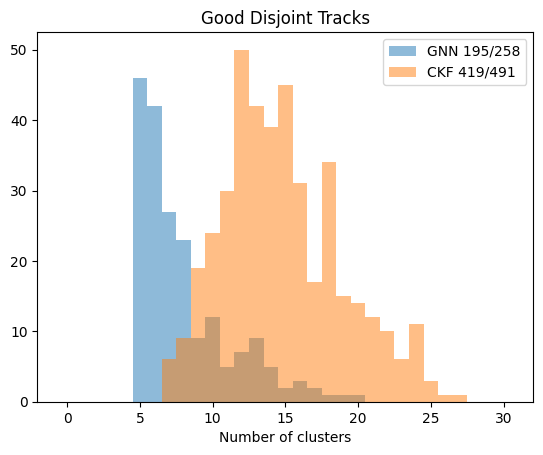

In [19]:
gnn_good_disjoints_tot_hits = gnn_good_disjoints.reco_pixel_hits + gnn_good_disjoints.reco_sct_hits
ckf_good_disjoints_tot_hits = ckf_good_disjoints.reco_pixel_hits + ckf_good_disjoints.reco_sct_hits

plt.title("Good Disjoint Tracks")
plt.hist(gnn_good_disjoints_tot_hits, bins=31, range=(-0.5,30.5),
            label=f"GNN {num_gnn_good_disjoints}/{num_gnn_disjoints}", alpha=0.5)
plt.hist(ckf_good_disjoints_tot_hits, bins=31, range=(-0.5,30.5),
            label=f"CKF {num_ckf_good_disjoints}/{num_ckf_disjoints}", alpha=0.5)
plt.legend()
plt.xlabel("Number of clusters")


In [20]:
particles = gnn_reader.particles

gnn_good_disjoints_matched_particles = particles[particles.particle_id.isin(gnn_good_disjoints.particle_id.values)]
ckf_good_disjoints_matched_particles = particles[particles.particle_id.isin(ckf_good_disjoints.particle_id.values)]


Text(0.5, 0, 'particle pT [MeV]')

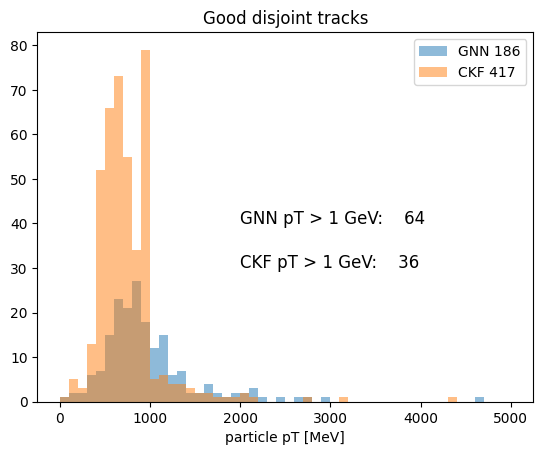

In [21]:
pt_gnn = gnn_good_disjoints_matched_particles.pt
pt_ckf = ckf_good_disjoints_matched_particles.pt
num_high_pt_gnn = len(pt_gnn[pt_gnn > 1000])
num_high_pt_ckf = len(pt_ckf[pt_ckf > 1000])

plt.title("Good disjoint tracks")
plt.hist(pt_gnn, bins=50, range=(0,5000), label=f"GNN {len(pt_gnn)}", alpha=0.5)
plt.text(2000, 40, f"GNN pT > 1 GeV: {num_high_pt_gnn:5}", fontsize=12)
plt.text(2000, 30, f"CKF pT > 1 GeV: {num_high_pt_ckf:5}", fontsize=12)
plt.hist(pt_ckf, bins=50, range=(0,5000), label=f"CKF {len(pt_ckf)}", alpha=0.5)
plt.legend()
plt.xlabel("particle pT [MeV]")

In [22]:
merged_gnn = gnn_good_disjoints_matched_particles.merge(gnn_good_disjoints, on='particle_id')
merged_ckf = ckf_good_disjoints_matched_particles.merge(ckf_good_disjoints, on='particle_id')

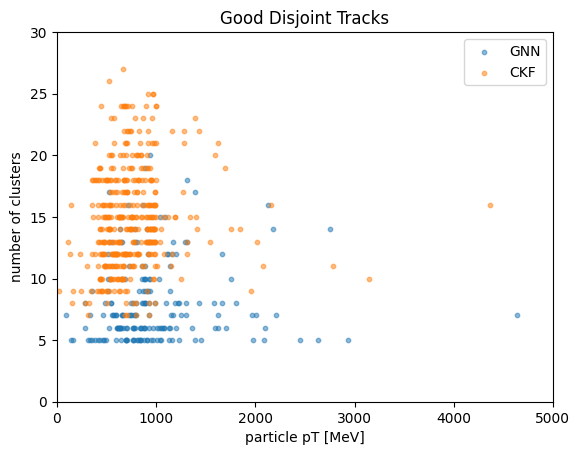

In [23]:
plt.title("Good Disjoint Tracks")
config = dict(s=10.0, alpha=0.5)
plt.scatter(merged_gnn.pt, 
            merged_gnn.reco_pixel_hits + merged_gnn.reco_sct_hits, label="GNN", **config)
plt.scatter(merged_ckf.pt,
            merged_ckf.reco_pixel_hits + merged_ckf.reco_sct_hits, label="CKF", **config)
plt.xlim(0, 5000)
plt.ylim(0, 30)
plt.xlabel("particle pT [MeV]")
plt.ylabel("number of clusters")
plt.legend()

## Good Disjoint Tracks from CKF with pT > 1 GeV
There are 36 tracks only found by CKF and matched to true particles with pT > 1 GeV. However, the track contents of those tracks are not used at all by GNN. Let's look at the details of these tracks. 

In [24]:
ckf_matched_pids = ckf_good_disjoints_matched_particles[pt_ckf > 1000].particle_id.values
ckf_disjoints_good_match = ckf_good_disjoints[ckf_good_disjoints.particle_id.isin(ckf_matched_pids)]

good_ckf_only_clusters = [ckf_reader.tracks_clusters[x] for x in ckf_disjoints_good_match.trkid.values]
good_ckf_only_clusters = np.array([item for sublist in good_ckf_only_clusters for item in sublist], dtype=int)
good_ckf_only_cluster_info = ckf_reader.clusters[ckf_reader.clusters.cluster_id.isin(good_ckf_only_clusters)]
good_ckf_only_cluster_info = good_ckf_only_cluster_info.assign(
    cluster_r=np.sqrt(good_ckf_only_cluster_info.cluster_x**2 + good_ckf_only_cluster_info.cluster_y**2))


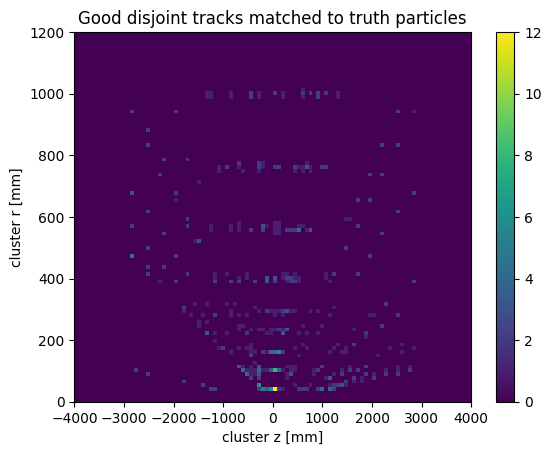

In [25]:
plt.title("Good disjoint tracks matched to truth particles")
plt.hist2d(good_ckf_only_cluster_info.cluster_z, good_ckf_only_cluster_info.cluster_r, bins=100, range=((-4000, 4000), (0, 1200)))
plt.xlabel("cluster z [mm]")
plt.ylabel("cluster r [mm]")
plt.colorbar()


# Common Tracks
There are 771 common tracks between GNN and CKF. Let's look at the details of these tracks.

Text(0.5, 0, 'number of clusters')

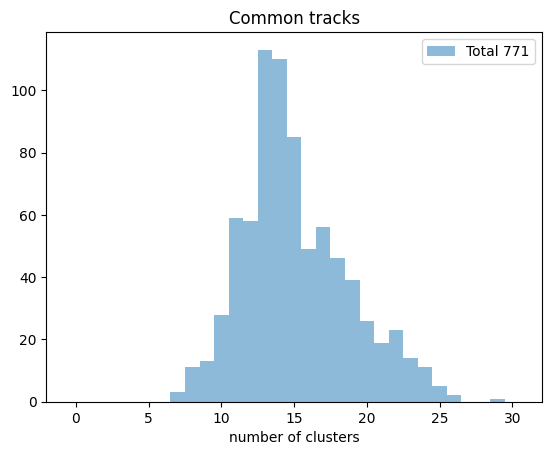

In [26]:
num_common_tracks = len(common_fil_gnn_tracks)

plt.title("Common tracks")
plt.hist([len(x[1]) for x in common_fil_gnn_tracks], bins=31, range=(-0.5,30.5),
         label=f"Total {num_common_tracks}", alpha=0.5)
plt.legend()
plt.xlabel("number of clusters")

In [27]:
gnn_chi2 = []
ckf_chi2 = []
for gnn_common_trkid, _, ckf_common_trkid in common_fil_gnn_tracks:
    found_gnn_track = gnn_reader.true_tracks.iloc[gnn_common_trkid]
    found_ckf_track = ckf_reader.true_tracks.iloc[ckf_common_trkid]
    gnn_chi2.append(found_gnn_track.chi2/found_gnn_track.nDoF)
    ckf_chi2.append(found_ckf_track.chi2 / found_ckf_track.nDoF)
    
gnn_chi2, ckf_chi2 = np.array(gnn_chi2), np.array(ckf_chi2)
delta_chi2 = gnn_chi2 - ckf_chi2

In [28]:
print(common_fil_gnn_tracks[0])
print(common_fil_gnn_tracks[4])
print("{:.6f}, {:.6f}".format(gnn_chi2[0], ckf_chi2[0]))
print("{:.6f}, {:.6f}".format(gnn_chi2[4], ckf_chi2[4]))

(13, [170007, 170083, 170153, 170229, 206124, 206293, 206160, 206332, 206201, 204650, 204743, 204843, 204945], 829)
(17, [168996, 169943, 169073, 170029, 169133, 170099, 170165, 206098, 206139, 206176, 204437, 202819, 204579, 204669, 204768, 204868], 251)
0.458252, 0.405440
0.396159, 0.490726


In [29]:
gnn_common_trkid, _, ckf_common_trkid = common_fil_gnn_tracks[0]
found_gnn_track = gnn_reader.true_tracks.iloc[gnn_common_trkid]
found_ckf_track = ckf_reader.true_tracks.iloc[ckf_common_trkid]
df = pd.DataFrame({"gnn": found_gnn_track, "ckf": found_ckf_track})
df

,gnn,ckf
trkid,13,829
fitter,5,5
material,3,3
nDoF,21,21
chi2,9.62329,8.51423
charge,1,1
x,-0.01613,-0.010554
y,-0.046478,-0.030339
z,-8.55869,-8.69545
px,871.72699,893.914978


In [30]:
found_gnn_track.particle_id, particles.particle_id.dtypes

('55670000811', dtype('O'))

In [31]:
pp = particles[ (particles.subevent == 5567) & (particles.barcode == 811)]
pp

,particle_id,subevent,barcode,px,py,pz,pt,eta,vx,vy,vz,radius,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode
71260,55670000811,5567,811,959.36,-335.444,-335.444,1016.31,3.8645,-0.0113,0.00857,-10.7464,0.014182,1,1.0,211,YES,1,3,0,-470


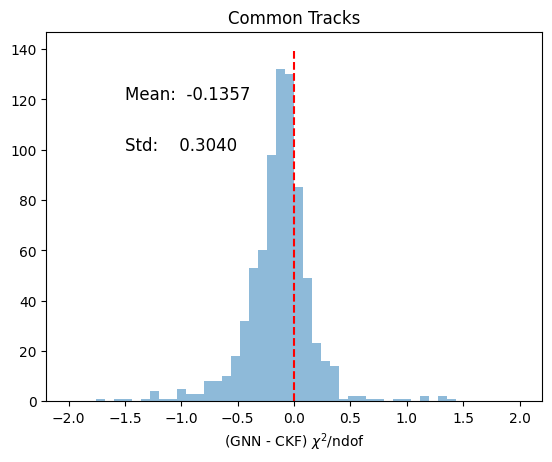

In [32]:
plt.title("Common Tracks")
plt.hist(delta_chi2, bins=50, range=(-2, 2), alpha=0.5)
plt.text(-1.5, 120, f"Mean: {np.mean(delta_chi2):8.4f}", fontsize=12)
plt.text(-1.5, 100, f"Std:  {np.std(delta_chi2):8.4f}", fontsize=12)
plt.xlabel("(GNN - CKF) $\chi^2$/ndof")
plt.plot([0, 0], [0, 140], color='red', linestyle='--')

Text(0, 0.5, 'CKF $\\chi^2$/ndof')

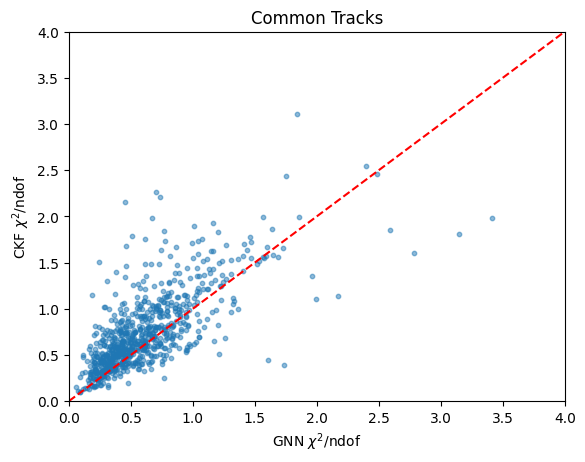

In [33]:
plt.title("Common Tracks")
plt.scatter(gnn_chi2, ckf_chi2, **config)
plt.plot([0, 4], [0, 4], color='red', linestyle='--')
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.xlabel("GNN $\chi^2$/ndof")
plt.ylabel("CKF $\chi^2$/ndof")